# Homework 04 - Applied ML

## Data Description

Soccer players (N = 2053) and all referees (N = 3147) that these players played under in their professional career. The data contains:

* the number of matches, players and referees encountered each other
* the number of red cards(dependent variable), given to a player by a particular referee (throughout all matches the two encountered each other)
* Player photos were available from the source for 1586 out of 2053 players
* Players’ skin tone was coded by two independent raters, 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value
* implicit bias scores for each referee country, race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations
* Explicit bias scores for each referee country, racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks.

Let's first import the necessary libraries so that we can read the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now let's get ahold of the data we will be working with!

In [2]:
soccer_data = pd.read_csv('CrowdstormingDataJuly1st.csv')
soccer_data.shape

(146028, 28)

That's a lot of data ;) Instead of using `head()`, let's print the first 14 columns and the next 14 seperately.

In [3]:
soccer_data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [4]:
soccer_data.ix[:5,14:]

,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


For a description of each feature check out the file `DATA.md`.

# Data Cleaning

Let's first clean the data a bit. The first thing we can do is drop those entries which have no rating for the skin color as we will not be able to do any training with this data or even evaluate our classifier with such entries.

In [5]:
soccer_data_clean = soccer_data[~soccer_data.photoID.isnull()]
soccer_data.shape[0] - soccer_data_clean.shape[0] # number of dropped players

21407

21407 entries have been dropped! The given data has an inconvenient structure for our analysis: each row is a _dyad_, which has a single player-referee interaction. This means that if a player has played games with more than 1 referee, that player will have several rows in this dataset. For example, let's look at everyone's favorite googly-eyed German: Mesut Ozil.

In [7]:
soccer_data_clean[(soccer_data_clean.playerShort == "mesut-oezil")][:5]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
26,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1051,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,1,...,0.25,66,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
1773,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,2,2,...,0.25,72,28,IRL,0.355498,4078.0,0.000098,0.517225,4238.0,0.000405
2852,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,14,11,...,0.25,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3407,mesut-oezil,Mesut Özil,Real Madrid,Spain,15.10.1988,183.0,76.0,Attacking Midfielder,1,0,...,0.25,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


As we can see certain _features_ of a player stay the same, e.g. his name, his height, and his weight. We will also assume that `club` and `leagueCountry` also stay the same during the player's career as is done in this dataset (I check with Zlatan Ibrahimovic who has gone between multiple clubs but the only one listed for him was PSG). Some other variables depend on the referee (see table below).

In the first exercise, we would like to predict the skin color of a player given his description and the second exercise asks to "aggregate the referee information grouping by soccer player". Therefore, we will have to perform some careful aggregation with those variables that depend on the referee. The table below describes how we will deal with each feature when performing aggregation.

| Feature  | Process  | Reason/Assumption  |
|---|---|---|
| _playerShort_  | Keep first  | Unique for player  |
| _player_  | Keep first  | Unique for player  |
| _club_  | Keep first  | Assuming player stays in same team  |
| _leagueCountry_  | Keep first  | Assumping player stays in same team  |
| _birthday_  | Keep first  | Unique for player  |
| _height_  | Keep first  | Assuming player does not grow or have a significant height increase during a single season.  |
| _weight_  | Keep first  | Assuming player does gain a significant amount of weight during a single season.  |
| _position_  | Keep first  | Assuming players has the same position during a single season.  |
| _games_  | Sum over rows  | Yields total number of games during the 2012/2013 season.  |
| _victories_  | Sum over rows  | Yields total number of victories.   |
| _ties_  | Sum over rows  | Yields total number of ties.  |
| _defeats_  | Sum over rows  | Yields total number of defeats.  |
| _goals_  | Sum over rows  | Yields total number of goals.  |
| _yellowCards_  | Sum over rows  | Yields total number of yellow cards.  |
| _yellowReds_  | Sum over rows  | Yields total number of red cards obtained by two yellow cards.  |
| _redCards_  | Sum over rows  | Yields total number of straight red cards.  |
| _photoID_  | Disregard  | Not needed the photo ID for our analysis.  |
| _rater1_  | Keep first  | Unique for player  |
| _rater2_  | Keep first  | Unique for player  |
| _refNum_  | Disregard  | Purpose of aggregation is to remove "relationship" with a particular referee.   |
| _refCountry_  | Disregard  | Purpose of aggregation is to remove "relationship" with a particular referee.  |
| <em>Alpha\_3</em>  | Disregard  | As it is another representation of the referee's country, we will also disregard this.  |
| _meanIAT_  | Disregard  | Computing weighted average.  |
| _nIAT_  | Disregard  | We do not believe this will help with the classification.  |
| _seIAT_  | Disregard  | We do not believe this will help with the classification.  |
| _meanExp_  | Disregard  | Computing weighted average.  |
| _nExp_  |  Disregard | We do not believe this will help with the classification.  |
| _seExp_  | Disregard  | We do not believe this will help with the classification.  |

First we will create a new DataFrame with `playerShort` as the index and we will sum over the necesary features/columns.

In [6]:
player_groups = soccer_data_clean.groupby("playerShort")
data_agg = player_groups[["games", "victories","ties","defeats","goals","yellowCards","yellowReds","redCards"]].aggregate(np.sum)
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
playerShort,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0
aaron-hunt,336,141,73,122,62,42,0,1
aaron-lennon,412,200,97,115,31,11,0,0
aaron-ramsey,260,150,42,68,39,31,0,1
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2


Now we will create a weighted sum of the mean implicit (IAT) and explicit (Exp) bias scores. Although such data is describing the referee and not the players, when we also take into account the number of cards a certain player received it could give some information on how a player might have been discriminated against.

In [7]:
ref_bias = soccer_data_clean[["playerShort", "games","meanIAT","meanExp"]].groupby("playerShort")
# weighted sum of mean IAT and Exp scores
def weighted_average(group, feature):
    weights = group['games']
    total_games = weights.sum()
    scores = group[feature]
    return (scores * weights).sum() / total_games
data_agg["weightedIAT"] = ref_bias.apply(weighted_average, 'meanIAT')   
data_agg["weightedExp"] = ref_bias.apply(weighted_average, 'meanExp') 
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp
playerShort,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895


We will also create a feature that contains the number of unique referees which gave each card type. Perhaps one referee was really biased towards a certain player.

In [8]:
# count number of non-zero entries, i.e. number of unique referees who have given the card
def num_unique_ref_card(group, card_type):
    ref_card = group[card_type]
    return (ref_card!=0).sum()

# count number of unique referees that have given a card to a particular player
def num_unique_ref(group):
    ref_cards = group['yellowCards']+group['yellowReds']+group['redCards']
    return (ref_cards!=0).sum()

data_agg['uniqueYellow'] = player_groups.apply(num_unique_ref_card, 'yellowCards')
data_agg['uniqueYellowReds'] = player_groups.apply(num_unique_ref_card, 'yellowReds')
data_agg['uniqueReds'] = player_groups.apply(num_unique_ref_card, 'redCards')
data_agg['uniqueRefCards'] = player_groups.apply(num_unique_ref)
data_agg.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,16,0,0,16
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,29,0,1,29
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,10,0,0,10
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,25,0,1,26
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,8,4,2,13


In [9]:
data_agg.tail()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
zoltan-gera,392,150,96,146,71,44,1,1,0.336001,0.417374,35,1,1,37
zoltan-stieber,142,48,37,57,27,12,0,0,0.336786,0.345085,12,0,0,12
zoumana-camara,395,148,117,130,7,46,2,6,0.338068,0.363993,30,2,6,33
zubikarai,47,14,15,18,0,2,0,2,0.369270,0.590521,2,0,2,4
zurutuza,160,68,39,53,12,22,0,0,0.368915,0.588902,16,0,0,16


Now we need to extract the features of a player that are constant: Name, Height, Weight, Birthday, Position and Skin Color ratings, Club, Country of the League.

In [11]:
# use "first" field of agg instead!
def extract_const_feat(group, param):
    return group[param].values[0]

const_feat = ["height","weight","club","leagueCountry","birthday","position","rater1","rater2"]
for feat in const_feat:
    data_agg[feat] = player_groups.apply(extract_const_feat, feat)
data_agg.ix[:5,:14]

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,uniqueYellow,uniqueYellowReds,uniqueReds,uniqueRefCards
playerShort,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,16,0,0,16
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,29,0,1,29
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,10,0,0,10
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,25,0,1,26
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,8,4,2,13


In [12]:
data_agg.ix[:5,14:]

,height,weight,club,leagueCountry,birthday,position,rater1,rater2
playerShort,,,,,,,,
aaron-hughes,182.0,71.0,Fulham FC,England,08.11.1979,Center Back,0.25,0.00
aaron-hunt,183.0,73.0,Werder Bremen,Germany,04.09.1986,Attacking Midfielder,0.00,0.25
aaron-lennon,165.0,63.0,Tottenham Hotspur,England,16.04.1987,Right Midfielder,0.25,0.25
aaron-ramsey,178.0,76.0,Arsenal FC,England,26.12.1990,Center Midfielder,0.00,0.00
abdelhamid-el-kaoutari,180.0,73.0,Montpellier HSC,France,17.03.1990,Center Back,0.25,0.25


We will use the `birthday` and today's date to compute the age of a player.

In [13]:
from datetime import datetime
def compute_age(player):
    return (datetime.now() - pd.to_datetime(player['birthday'])).days/365
data_agg['age'] = data_agg.apply(compute_age, axis=1)
data_agg.drop('birthday', axis=1, inplace=True)

Finally, we will need to use [_dummy encoding_](https://en.wikiversity.org/wiki/Dummy_variable_(statistics) for those features that are not numeric: `club`, `leagueCountry`, and `position`.

In [14]:
data_agg.dtypes

games                 int64
victories             int64
ties                  int64
defeats               int64
goals                 int64
yellowCards           int64
yellowReds            int64
redCards              int64
weightedIAT         float64
weightedExp         float64
uniqueYellow          int64
uniqueYellowReds      int64
uniqueReds            int64
uniqueRefCards        int64
height              float64
weight              float64
club                 object
leagueCountry        object
position             object
rater1              float64
rater2              float64
age                 float64
dtype: object

Luckily, `pandas` has a function to do this dummy encoding for us ;)

In [53]:
pd.get_dummies(data_agg).head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,...,position_Center Forward,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, we need to combine the two skin rating values into a single value corresponding to the skin color of the player; this combination will be done by taking the average of the two.

In [54]:
# Label two different skin colors according to rate average: 0-white, 1-black.
def rate_average_label(group):
    return (group['rater1'].values[0]+ group['rater2'].values[0])/2
#     rate_average = (group['rater1'].values[0]+ group['rater2'].values[0])/2
#     if rate_average >= 0.5:
#         return 1
#     else:
#         return 0

player_data = pd.get_dummies(data_agg)
player_data["skin_label"] = player_groups.apply(rate_average_label) 
player_data.drop(['rater1','rater2'], axis=1, inplace=True)
player_data.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,weightedIAT,weightedExp,...,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,skin_label
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,654,247,179,228,9,19,0,0,0.333195,0.400637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-hunt,336,141,73,122,62,42,0,1,0.341438,0.380811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-lennon,412,200,97,115,31,11,0,0,0.332389,0.399459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.250
aaron-ramsey,260,150,42,68,39,31,0,1,0.336638,0.433294,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331882,0.328895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250


In [55]:
player_data.shape

(1585, 131)

Below we observe that the DataFrame has `NaN` values for the height and weight of some players.

In [180]:
print(player_data.isnull().any(axis=0).sum()) # two columns have NaN values - height and weight
player_data.isnull().any(axis=0)[:17]

2


games               False
victories           False
ties                False
defeats             False
goals               False
yellowCards         False
yellowReds          False
redCards            False
weightedIAT         False
weightedExp         False
uniqueYellow        False
uniqueYellowReds    False
uniqueReds          False
uniqueRefCards      False
height               True
weight               True
age                 False
dtype: bool

In [57]:
player_data[player_data.isnull().any(axis=1)].shape[0]

21

We will remove these 21 players before beginning classification.

In [128]:
player_data_clean = player_data.dropna()

Just to check `NaN` we dropped successfully:

In [129]:
print(player_data.shape[0] - player_data_clean.shape[0])  # check number of dropped players is 21
print(player_data_clean.isnull().any(axis=1).sum())       # check 0 players with NaN data

21
0


## Threshold for classification

In the exercises that follow, we will stick to binary classification (light or dark skin) rather than multiclass (there are 9 possible values for rating the skin color after averaging). With only two ratings, the uncertainty margin may be too large to allow for precise classification into multiple classes.

We could not find official statistics on the number of black players but this is what we have found online:
* 183/568 = 32.22% black players in the English Premier League in 2012/2013 (http://www.sportingintelligence.com/2012/08/20/premier-league-diversity-at-heart-of-global-appeal-200801/)
* ~38% in the French league (https://answers.yahoo.com/question/index?qid=20100109151925AAsWDT9)
* ~11% in the Spanish league (https://answers.yahoo.com/question/index?qid=20100109151925AAsWDT9)

If we assume ~11% for the German league as well (the English league is known to be very diverse and the French league has a lot of players of African origin due to much of African being [francophone](http://spiritofmirko.com/2013/03/06/african-footballers-in-the-premier-league-la-liga-ligue-1-serie-a-and-the-bundesliga/) so this is a "safe" estimate), we can compute the rough percentage of black players in our dataset as follows.

In [114]:
# compute weighted average
country_perc = np.array([32.22,38,11,11])
country_perc = {'England': 32.88, 'France': 38, 'Spain':11, 'Germany':11}
players_per_country = {}
players_per_country['England'] = sum(player_data_clean.leagueCountry_England)
players_per_country['France'] = sum(player_data_clean.leagueCountry_France)
players_per_country['Spain'] = sum(player_data_clean.leagueCountry_Spain)
players_per_country['Germany'] = sum(player_data_clean.leagueCountry_Germany)
    
tot_players = player_data_clean.shape[0]
print(players_per_country)
sum([players_per_country[key]*country_perc[key] for key in players_per_country])/tot_players

{'France': 278.0, 'Germany': 478.0, 'England': 370.0, 'Spain': 438.0}


20.975447570332481

As we have less players from leagues with a large number of black players (England and France), our expected percentage of black players in the dataset is lower - 20.98%.

Let's have a quick look at the distribution of skin color ratings in our dataset.

In [71]:
player_data_clean.skin_label.value_counts()

0.250    466
0.000    418
0.125    225
0.500    115
0.750    100
1.000     90
0.375     77
0.875     40
0.625     33
Name: skin_label, dtype: int64

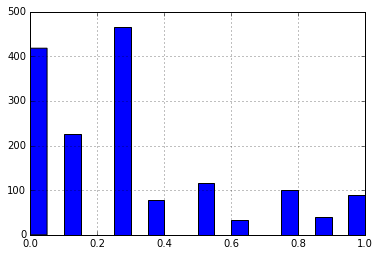

In [81]:
player_data_clean.skin_label.hist(bins=20)

The `quantile` function will give us a threshold such that ~20.98 percentage of scores are above and the rest below.

In [118]:
THRESH = player_data_clean.skin_label.quantile(1-0.2098)
THRESH

0.5

In [152]:
def apply_threshold(player):
    if player.skin_label > THRESH:
        return 1
    else: return 0

player_data_bin = player_data_clean.copy()
player_data_bin["skin_label"] = player_data_bin.apply(apply_threshold,axis=1)
player_data_bin.skin_label.value_counts()

0    1301
1     263
Name: skin_label, dtype: int64

This gives about 24.17% black players in our dateset (using `> THRESH` rather than `>=THRESH` yields 16.81% which is further from 20.98).

# Exercise 1 - Classification

<em>Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?</em>

### Import libraries and split data

In [421]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics

RANDOM_SEED = 0

First we need to split the data into training and testing sets.

In [448]:
# split input (features) and output (skin label)
n_sample = player_data_bin.shape[0] #1564
n_feature = player_data_bin.shape[1]-1 #130
X = player_data_bin.ix[:,:n_feature]
Y = player_data_bin.ix[:,n_feature]
# split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)

### How different parameters passed to Classifier affect the overfitting issue

**NOTE** Normally, we would not touch the test set till the very end. However, to emphasize "how different parameters passed to Classifier affect the overfitting issue" we will use it now.

Let's keep the number of trees (`n_estimators`) fixed at 30 and vary the maximum depth of the tress (`max_depth`) as so:

In [423]:
depth_vals = range(1,30)

Now we will compute the training and testing error when training a model for each of these values of the maximum depth of the tree.

In [424]:
n_estimators = 30
train_acc = np.zeros(len(depth_vals)) 
test_acc = np.zeros(len(depth_vals)) 
for max_depth in depth_vals:
    forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_SEED)
    forest = forest.fit(X_train, Y_train)
    # compute predictions
    Y_train_pred = forest.predict(X_train)
    Y_test_pred = forest.predict(X_test)
    # calculate accuracy
    train_acc[max_depth-1] = 1-metrics.accuracy_score(Y_train, Y_train_pred)
    test_acc[max_depth-1] = 1-metrics.accuracy_score(Y_test, Y_test_pred)

Let's plot the "learning curve" for this overfitting demonstration.

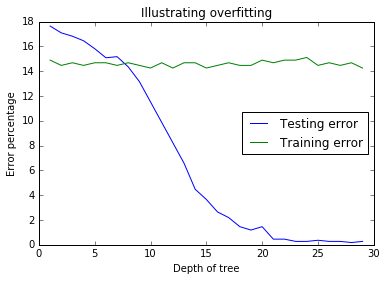

In [425]:
plt.figure()
plt.plot(depth_vals, train_acc*100, label='Testing error')
plt.plot(depth_vals, test_acc*100, label='Training error')
plt.xlabel('Depth of tree')
plt.ylabel('Error percentage')
# plt.legend('Training Error', 'Testing Error')
plt.legend(loc='center right')
plt.title('Illustrating overfitting')
plt.show()

As we can see in the plot above, increasing the depth of the tree leads to overfitting as the training error rapidly approaches zero but the testing error does not budge. This gap between the training error and testing error for the larger values of the maximum tree depth is characteristic of overfitting - even though the model works very well on the training data, it does not perform as well on unseen data.

Now why do we get overfitting for larger values of the maximum tree depth? We can explain this with the following intuitive approach. If we think of going deeper in the tree as being able to "ask more questions" with a larger maximum depth our classifier can "ask more questions" and will fit to our training data very well. Therefore, ncreasing the depth does not help with generalizing on unseen data.

### Perform cross-validation to mitigate the overfitting of your model

`scikit-learn` has some really powerful function to perform cross-validation. We will be using the `GridSearchCV` class.

In [426]:
# import class for stratified k-fold cross validation
from sklearn.model_selection import GridSearchCV

With this class, we can perform a grid search over the desired set of model parameters to tune. For our Random Forest classifier, we are interested in selecting the ideal number of trees (`n_estimators`) and maximum tree depth (`max_depth`). We will search over the following values for these parameters:

* `n_estimators`: 5 to 150 in steps of 10
* `max_depth`: 1 to 31 in steps of 2

In [449]:
param_grid = [{'max_depth': list(range(1,31,2)), 'n_estimators': list(range(5,150,10)), 'random_state':[RANDOM_SEED]}]

Now we will initialize the estimator (`RandomForestClassifier`) and grid search (`GridSearchCV`) objects. The parameters of the estimator will be changed by the values in `param_grid`. The parameter `cv` for `GridSearchCV` allows us to set the number of folds in a Stratified K-fold cross-validation. Stratified means there is roughly the same percentage of samples of each target class as the complete set.

In [450]:
forest = ensemble.RandomForestClassifier(n_estimators=..., max_depth=..., random_state=RANDOM_SEED)
gs = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5)

When we call `fit` of the grid search object, it will apply the `fit` of our Random Forest estimator on 5 folds for each pair of parameter values.

In [451]:
gs = gs.fit(X_train, Y_train)

Let's see what values were selected for our parameters by this grid search and cross-validation.

In [452]:
print(gs.best_params_)
print(gs.best_score_) # corresponding score, gives an estimate of the error on unseen data

{'max_depth': 13, 'n_estimators': 25, 'random_state': 0}
0.837294332724


Let's predict on the test set.

In [453]:
print(gs.score(X_test,Y_test))

0.857446808511


Quite close to the estimated test error we obtained by cross validation.

### Once you assessed your model, inspect the ` feature_importances_` attribute and discuss the results.

Let's inspect the "important features" to get an idea of how the Random Forest is classifiying a player as black or white. We have created our own function `print_important_features` to nicely print the top features.

In [454]:
from hw4_utils import print_important_features
feature_name = player_data_bin.columns.values.tolist()
print_important_features(feature_name, gs.best_estimator_.feature_importances_, top_k=25)

Features sorted by their score:
1. weightedExp (0.091000)
2. weightedIAT (0.088300)
3. games (0.055000)
4. age (0.049500)
5. victories (0.049200)
6. yellowCards (0.048200)
7. defeats (0.048000)
8. ties (0.042000)
9. goals (0.040600)
10. weight (0.039800)
11. height (0.039100)
12. uniqueYellow (0.037100)
13. uniqueRefCards (0.035500)
14. leagueCountry_France (0.029200)
15. club_Olympique Marseille (0.028200)
16. uniqueReds (0.014900)
17. redCards (0.014800)
18. uniqueYellowReds (0.014700)
19. leagueCountry_Germany (0.014500)
20. leagueCountry_Spain (0.014000)
21. yellowReds (0.012700)
22. club_Olympique Lyon (0.011600)
23. leagueCountry_England (0.011100)
24. position_Center Forward (0.007700)
25. position_Goalkeeper (0.006800)
The feature importance propotion of the top 25 : 0.843500


We can also check the least important features with another custom function.

In [456]:
from hw4_utils import print_unimportant_features
print_unimportant_features(feature_name, gs.best_estimator_.feature_importances_, bottom_k=25)

Features sorted by their score:
1. club_Arsenal FC (R) (0.000000)
2. club_Blackburn Rovers (0.000000)
3. club_Bolton Wanderers (0.000000)
4. club_Bristol City (0.000000)
5. club_CF Badalona (0.000000)
6. club_Celta Vigo (0.000000)
7. club_Crewe Alexandra (0.000000)
8. club_Deportivo La Coruña (0.000000)
9. club_FC Schalke 04 (0.000000)
10. club_Fortuna Düsseldorf (0.000000)
11. club_Leeds United (0.000000)
12. club_Leicester City (0.000000)
13. club_Leyton Orient (0.000000)
14. club_Liverpool FC (R) (0.000000)
15. club_MSV Duisburg (0.000000)
16. club_Millwall FC (0.000000)
17. club_Nottingham Forest (0.000000)
18. club_OGC Nice (0.000000)
19. club_Real Jaén (0.000000)
20. club_Real Madrid Castilla (0.000000)
21. club_SD Compostela (0.000000)
22. club_Southampton FC (0.000000)
23. club_Tottenham Hotspur (R) (0.000000)
24. club_US Boulogne (0.000000)
25. club_Valencia CF (0.000000)
The feature importance propotion of the bottom 25 : 0.000000


It seems as though the team/club of the player is not generally important in determining the skin color of a player. There are a few notable exceptions: Marseille, Lyon, and Stade Brest. Their importance and the importance of the player being in the French league are in line with the observations from [this article](http://spiritofmirko.com/2013/03/06/african-footballers-in-the-premier-league-la-liga-ligue-1-serie-a-and-the-bundesliga/).

Furthermore, the weighted IAT and Exp racial bias scores of the referees faced by a player seem to be the most important features. Perhaps these features combined with the unique number of referees who have given yellow cards (`uniqueYellow`) and the unique number of referees (`uniqueRefCards`) who have given yellow and red cards are able to help the classifier distinguish between black and white players.

### With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

We will make the following assumptions (NOT conclusions/observations) to see if we can obtain a substantially difference result for the feature importances:

* Position and club are not important as seen in the importance values before, so we won't feed them to the classifier
* The country may play an important role (as France has a higher percentage of black players)
* We will keep age as it had high importance: perhaps more younger players are black as the top flight leagues have become more and more diverse
* We will keep games: perhaps some coaches have some bias towards race as well
* We will keep height and weight as these could be physical characteristics that differ by race for soccer players
* And we will keep yellow card information in case there is bias among referees
* Finally we will drop the weighted IAT and Exp scores to see if the classifier can still perform well and to see how other features might become more important

So let's trim the data we give to the classifier.

In [458]:
des_feat = ["games", "age", "leagueCountry_France", "height", "weight", "uniqueYellow", "yellowCards"]
player_data_trim = player_data_bin[des_feat]
player_data_trim.head()

,games,age,leagueCountry_France,height,weight,uniqueYellow,yellowCards
playerShort,,,,,,,
aaron-hughes,654,37.315068,0.0,182.0,71.0,16,19
aaron-hunt,336,30.649315,0.0,183.0,73.0,29,42
aaron-lennon,412,29.630137,0.0,165.0,63.0,10,11
aaron-ramsey,260,25.931507,0.0,178.0,76.0,25,31
abdelhamid-el-kaoutari,124,26.709589,1.0,180.0,73.0,8,8


Let's split the data similar to before. We can keep the same output labels (`Y`) as this will not change.

In [459]:
# split input (features) and output (skin label)
n_sample = player_data_trim.shape[0] #1564
n_feature = player_data_trim.shape[1]
X_trim = player_data_trim
# split
X_train, X_test, Y_train, Y_test = train_test_split(X_trim, Y, test_size=0.3, random_state=RANDOM_SEED)

We will create a grid search over fewer points:

In [460]:
param_grid_trim = [{'max_depth': list(range(1,21,2)), 'n_estimators': list(range(5,50,5)), 'random_state':[RANDOM_SEED]}]
gs_trim = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5)

Now let's train the Random Forest by performing the corresponding grid search with 20 folds.

In [461]:
gs_trim = gs_trim.fit(X_train, Y_train)

Let's take a look at the optimal values (from this grid search) for the number of trees and maximum depth as well as the estimated accuracy on unseen data.

In [462]:
print(gs_trim.best_params_)
print(gs_trim.best_score_) # corresponding score, gives an estimate of the error on unseen data

{'max_depth': 3, 'n_estimators': 35, 'random_state': 0}
0.826325411335


Let's see how this compares to "actual" unseen data.

In [463]:
print(gs_trim.score(X_test,Y_test))

0.851063829787


Now let's check how the importances may have changed.

In [464]:
feature_name = player_data_trim.columns.values.tolist()
print_important_features(feature_name, gs_trim.best_estimator_.feature_importances_, top_k=len(des_feat))

Features sorted by their score:
1. leagueCountry_France (0.360800)
2. yellowCards (0.162300)
3. age (0.123500)
4. games (0.120700)
5. weight (0.098600)
6. uniqueYellow (0.079900)
7. height (0.054000)
The feature importance propotion of the top 7 : 0.999800


Dropping a lot of the features has increased the importance of each of the (remaining) features as is expected since the feature importances must sum to one. But this gives us a better idea of the relative importances since the scores are really spread out among a lot features in the previous case.

Most "importantly", the importance of playing in the French league has shot up compared to the other features! The accuracy of the classifier has still stayed relatively the same while the maximum depth has decreased from 13 to 3; maybe we have a more general classifier.

Let's try one more thing: removing the weighted IAT and Exp scores but keeping everything else to see how feature importances change. 

(As a note/reminder, this is a feature that we previously assumed to be important when combined with the number of cards and unique referees that have given cards.)

In [465]:
player_data_trim = player_data_bin.drop(['weightedIAT','weightedExp','skin_label'], axis=1)
# split input (features) and output (skin label)
n_sample = player_data_trim.shape[0] #1564
n_feature = player_data_trim.shape[1]
X_trim = player_data_trim
# split
X_train, X_test, Y_train, Y_test = train_test_split(X_trim, Y, test_size=0.3, random_state=RANDOM_SEED)

We will use the same grid search object with 5 folds as before. Now let's do some training.

In [466]:
gs_trim = gs_trim.fit(X_train, Y_train)

Let's make sure the accuracy hasn't been severly compromised.

In [467]:
print(gs_trim.best_params_)
print(gs_trim.best_score_) # corresponding score, gives an estimate of the error on unseen data
print(gs_trim.score(X_test,Y_test)) # actual test score

{'max_depth': 7, 'n_estimators': 35, 'random_state': 0}
0.830895795247
0.853191489362


It hasn't :) Now let's check how the feature importances may have changed.

In [468]:
feature_name = player_data_trim.columns.values.tolist()
print_important_features(feature_name, gs_trim.best_estimator_.feature_importances_, top_k=25)

Features sorted by their score:
1. leagueCountry_France (0.088400)
2. age (0.063300)
3. uniqueYellow (0.059000)
4. yellowCards (0.056500)
5. games (0.054500)
6. victories (0.051400)
7. goals (0.051300)
8. defeats (0.047500)
9. club_Olympique Marseille (0.047100)
10. weight (0.044700)
11. ties (0.040000)
12. uniqueRefCards (0.031700)
13. height (0.028000)
14. uniqueReds (0.019900)
15. club_Olympique Lyon (0.016000)
16. uniqueYellowReds (0.015300)
17. leagueCountry_Spain (0.015100)
18. redCards (0.014600)
19. position_Goalkeeper (0.014600)
20. position_Center Forward (0.013600)
21. leagueCountry_England (0.013600)
22. club_Stade Rennes (0.012100)
23. club_Stade Brest (0.011300)
24. position_Left Winger (0.010800)
25. leagueCountry_Germany (0.010500)
The feature importance propotion of the top 25 : 0.830800


The most significant change is: whether or not a player is in the French league and number of yellow cards have gone up in the feature importance rankings. The other features seem to have changed by a couple percentage points at most. Therefore, the weighted IAT and Exp scores do not seem to be as important as previously observed. Perhaps the information they bring is reflected by the features `leagueCountry_France` and `uniqueYellow`. This is just a hunch and would require more in depth statistical analysis.

### Confusion Matrix

Let's go back to using all the features and compute a confusion matrix to see in which cases our classifier performs well/poor.

In [550]:
from sklearn.metrics import confusion_matrix, f1_score

We will use the best estimator which will be used when we call the `predict` method of the `gs`, which is the `GridSearchCV` object we had when using all features.

In [544]:
Y_test_pred = gs.predict(X_test)

In [548]:
confusion_matrix(Y_test, Y_test_pred)

array([[393,   7],
       [ 60,  10]])

In [553]:
print(f1_score(Y_test, Y_test_pred))
print(gs.score(X_test,Y_test))

0.229885057471
0.857446808511


Although the accuracy is decent (85.7%), we can observe from the confusion matrix that the classifier does very poorly in the classifying black players. Only around 14.3% (10/70) are correctly classified. The F1 score (between 0 and 1, with 1 being best) highlights this poor performance of the classifier with a value of 0.230.

Moreover, the precision for identifying white players is 86.75% (393/453) while the precision for identifying black players is only 58.82% (10/17).

# BONUS

_Plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?_

From [sklearn](http://scikit-learn.org/stable/modules/learning_curve.html): _A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data._

We will use the `learning_curve` function of `sklearn` in order to generate the values needed to create such a plot. Moreover, a script is already available through the `sklearn` [site](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) to plot learning curves. We have put the core function from this script in the `hw4_utils` file.

In [514]:
from hw4_utils import plot_learning_curve

We will use all the features:

In [515]:
# split input (features) and output (skin label)
n_sample = player_data_bin.shape[0] #1564
n_feature = player_data_bin.shape[1]-1 #130
X = player_data_bin.ix[:,:n_feature]
Y = player_data_bin.ix[:,n_feature]

Our estimator/classifier is the Random Forest that we found with the optimal parameters for the number of trees (25) and the maximum depth (13).

In [527]:
estimator = ensemble.RandomForestClassifier(n_estimators=25, max_depth=13, random_state=RANDOM_SEED)

<module 'matplotlib.pyplot' from '/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py'>

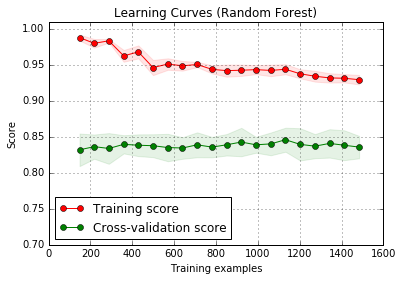

In [534]:
title = "Learning Curves (Random Forest)"
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=25, train_sizes=np.linspace(.1, 1.0, 20))

As we can see in the plot above:

* When we have very few data examples, our model overfits as we have a larger gap between the training and cross-validation score.
* We also observe that the cross-validation score could possibly be increased by obtaining more training samples.

If we want to get a set of parameters that lead to high bias, we should use **shallow trees**. Let's try setting the max depth to 3.

<module 'matplotlib.pyplot' from '/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py'>

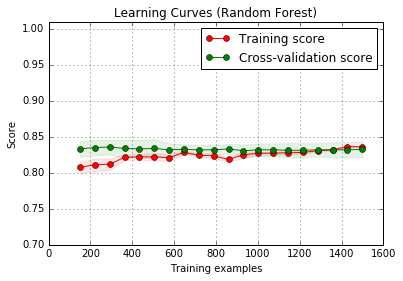

In [537]:
estimator = ensemble.RandomForestClassifier(n_estimators=25, max_depth=3, random_state=RANDOM_SEED)
title = "Learning Curves (Random Forest)"
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=25, train_sizes=np.linspace(.1, 1.0, 20))

Voila! Here we observe that the training error is even falling slightly below the cross-validation error. This is probably due to high bias as we are using too simple of a model.

As was shown in class, we can reduce bias by increasing depth and we can reduce variance by increasing the number of trees. In this first case, we seemed to have high variance as there was a gap between the training and cross-validation curves (perhaps the model is fitting the training data too closely). Let's try increasing the number of trees to 500 (with max depth = 13).

<module 'matplotlib.pyplot' from '/Users/eric/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py'>

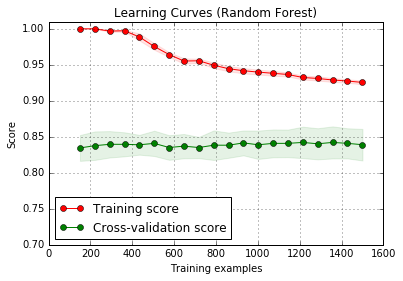

In [538]:
estimator = ensemble.RandomForestClassifier(n_estimators=500, max_depth=13, random_state=RANDOM_SEED)
title = "Learning Curves (Random Forest)"
plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=25, train_sizes=np.linspace(.1, 1.0, 20))

At the beginning we have high bias since the model is very complex (500 trees for few training samples). However, it seems as though increasing the number of trees does not reduce the gap. Perhaps the solution then is that we need more training samples.